In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import copy
from models import *
from samplers import *
from torch.amp import GradScaler, autocast
import matplotlib.gridspec as gridspec
import random
from dataloaders import *

T = 1000
IMG_SIZE = 64
EMBED_DIM = 128
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

weights_dir = "weights"

print("torch:", torch.__version__)
print("torch cuda build:", torch.version.cuda)
print("cuda available:", torch.cuda.is_available())
print("CUDA_VISIBLE_DEVICES:", os.getenv("CUDA_VISIBLE_DEVICES"))

In [ ]:
full_ds = PairsDatasetUnified(
    root_dir=".",
    norm_preset="minmax",
    out_range="[-1,1]",
    pad_to=48,
    noise_aug=None,               # skip extra noise
    return_order="HRLR"
)

n_total = len(full_ds)
n_train = int(0.9 * n_total)
train_ds, test_ds = random_split(full_ds, [n_train, n_total - n_train],
                                 generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print(f"Total: {n_total}, Train: {len(train_ds)}, Test: {len(test_ds)}")

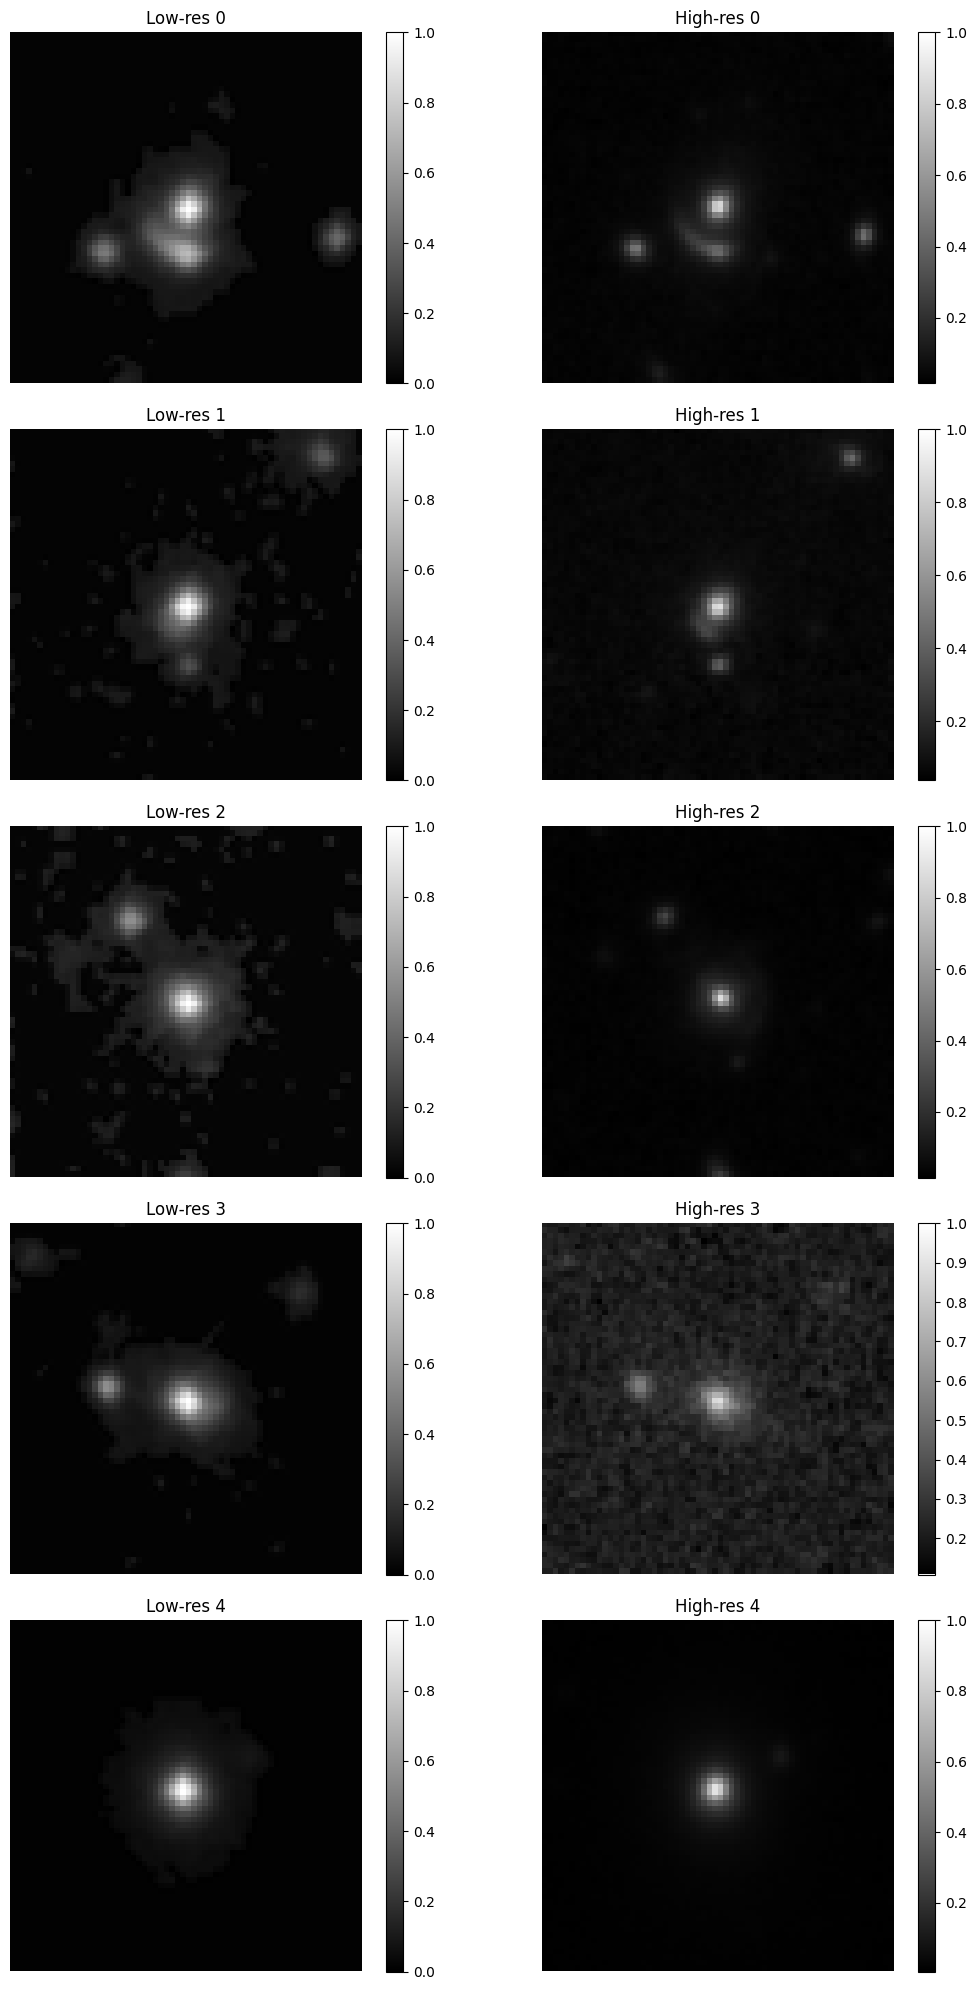

In [ ]:
vmax_lr = 1.0
vmax_hr = 1

num_samples = 5

fig, axs = plt.subplots(num_samples, 2, figsize=(12, num_samples * 4))

for i in range(num_samples):
    x0, x_cond = train_ds[i]  # x0 = high-res, x_cond = low-res

    # Convert from [-1, 1] to [0, 1] for display
    x0 = (x0 ).squeeze().numpy()
    x_cond = (x_cond ).squeeze().numpy()

    im1 = axs[i, 0].imshow(x_cond, cmap='gray', vmax = vmax_lr)
    axs[i, 0].set_title(f"Low-res {i}")
    axs[i, 0].axis('off')
    plt.colorbar(im1, ax=axs[i,0], fraction=0.046, pad=0.04)

    im2 = axs[i, 1].imshow(x0, cmap='gray', vmax = vmax_hr)
    axs[i, 1].set_title(f"High-res {i}")
    axs[i, 1].axis('off')
    plt.colorbar(im2, ax=axs[i,1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

### Load weights

In [5]:
model = UNet_512_mix_attn_conditional(use_cond_pyr=True, use_global_cond=True).to(DEVICE)
ema_model = copy.deepcopy(model).to(DEVICE)
for param in ema_model.parameters():
    param.requires_grad = False

# model.load_state_dict(torch.load(f"{weights_dir}/grav_model_100_res_imp_mejiro_lsst_pyr_glob.pt"), strict = False)    
# ema_model.load_state_dict(torch.load(f"{weights_dir}/grav_ema_model_100_res_imp_mejiro_lsst_pyr_glob.pt"), strict=False)

### Training loop

In [ ]:
# Setup optimizer, scheduler, and scaler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10, min_lr=1e-7
)
scaler = GradScaler('cuda')

train_losses = []
test_losses = []

for epoch in range(200):
    model.train()
    epoch_loss = 0

    for x0, x_cond in train_loader:  
        x0 = x0.to(DEVICE)
        x_cond = x_cond.to(DEVICE) 

        t = torch.randint(0, T, (x0.size(0),), device=DEVICE)
        noise = torch.randn_like(x0)
        x_t = q_sample(x0, t, noise)
        t_emb = get_timestep_embedding(t, EMBED_DIM)
        target = noise

        optimizer.zero_grad()

        with autocast(device_type = 'cuda'):  # AMP forward pass
            pred = model(x_t, t_emb, x_cond)  
            loss = F.mse_loss(pred, target)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        update_ema(ema_model, model, decay=0.999)

        epoch_loss += loss.item() * x0.size(0)



    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1} | Train Loss: {epoch_loss:.8f}")
 
    if (epoch + 1) % 100 == 0:
        torch.save(model.state_dict(), f"grav_model_{epoch+1}_res_imp_hsthsc_pyr_glob_cond_dropout.pt")
        torch.save(ema_model.state_dict(), f"grav_ema_model_{epoch+1}_res_imp_hsthsc_pyr_glob_cond_dropout.pt")
        print(f"✅ Saved models at epoch {epoch+1}")

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x0, x_cond in test_loader:  
            x0 = x0.to(DEVICE)
            x_cond = x_cond.to(DEVICE)

            t = torch.randint(0, T, (x0.size(0),), device=DEVICE)
            noise = torch.randn_like(x0)
            x_t = q_sample(x0, t, noise)
            t_emb = get_timestep_embedding(t, EMBED_DIM)
            target = noise

            with autocast(device_type = 'cuda'):
                pred = model(x_t, t_emb, x_cond)
                loss = F.mse_loss(pred, target)

            test_loss += loss.item() * x0.size(0)

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print(f"Epoch {epoch+1} | Test Loss: {test_loss:.8f}")

    # --- LR scheduling ---
    scheduler.step(test_loss)
    print('current lr = ' + str(optimizer.param_groups[0]['lr']))

# --- Plot ---
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.yscale('log')
plt.title('Loss Curves')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1 | Train Loss: 0.42900304
Epoch 1 | Test Loss: 0.11367296
current lr = 0.0001
Epoch 2 | Train Loss: 0.05892310
Epoch 2 | Test Loss: 0.05793835
current lr = 0.0001
Epoch 3 | Train Loss: 0.03358138
Epoch 3 | Test Loss: 0.03367980
current lr = 0.0001
Epoch 4 | Train Loss: 0.02299875
Epoch 4 | Test Loss: 0.01817473
current lr = 0.0001
Epoch 5 | Train Loss: 0.02284420
Epoch 5 | Test Loss: 0.04650907
current lr = 0.0001
Epoch 6 | Train Loss: 0.01731437
Epoch 6 | Test Loss: 0.01543930
current lr = 0.0001
Epoch 7 | Train Loss: 0.01557422
Epoch 7 | Test Loss: 0.06619114
current lr = 0.0001
Epoch 8 | Train Loss: 0.01191889
Epoch 8 | Test Loss: 0.02318055
current lr = 0.0001
Epoch 9 | Train Loss: 0.01219830
Epoch 9 | Test Loss: 0.02182707
current lr = 0.0001
Epoch 10 | Train Loss: 0.01079337
Epoch 10 | Test Loss: 0.02504417
current lr = 0.0001
Epoch 11 | Train Loss: 0.01051510
Epoch 11 | Test Loss: 0.01472986
current lr = 0.0001
Epoch 12 | Train Loss: 0.00921762
Epoch 12 | Test Loss: 0.015

### Sampling

/tmp/user/1015/ipykernel_3216137/2739588192.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


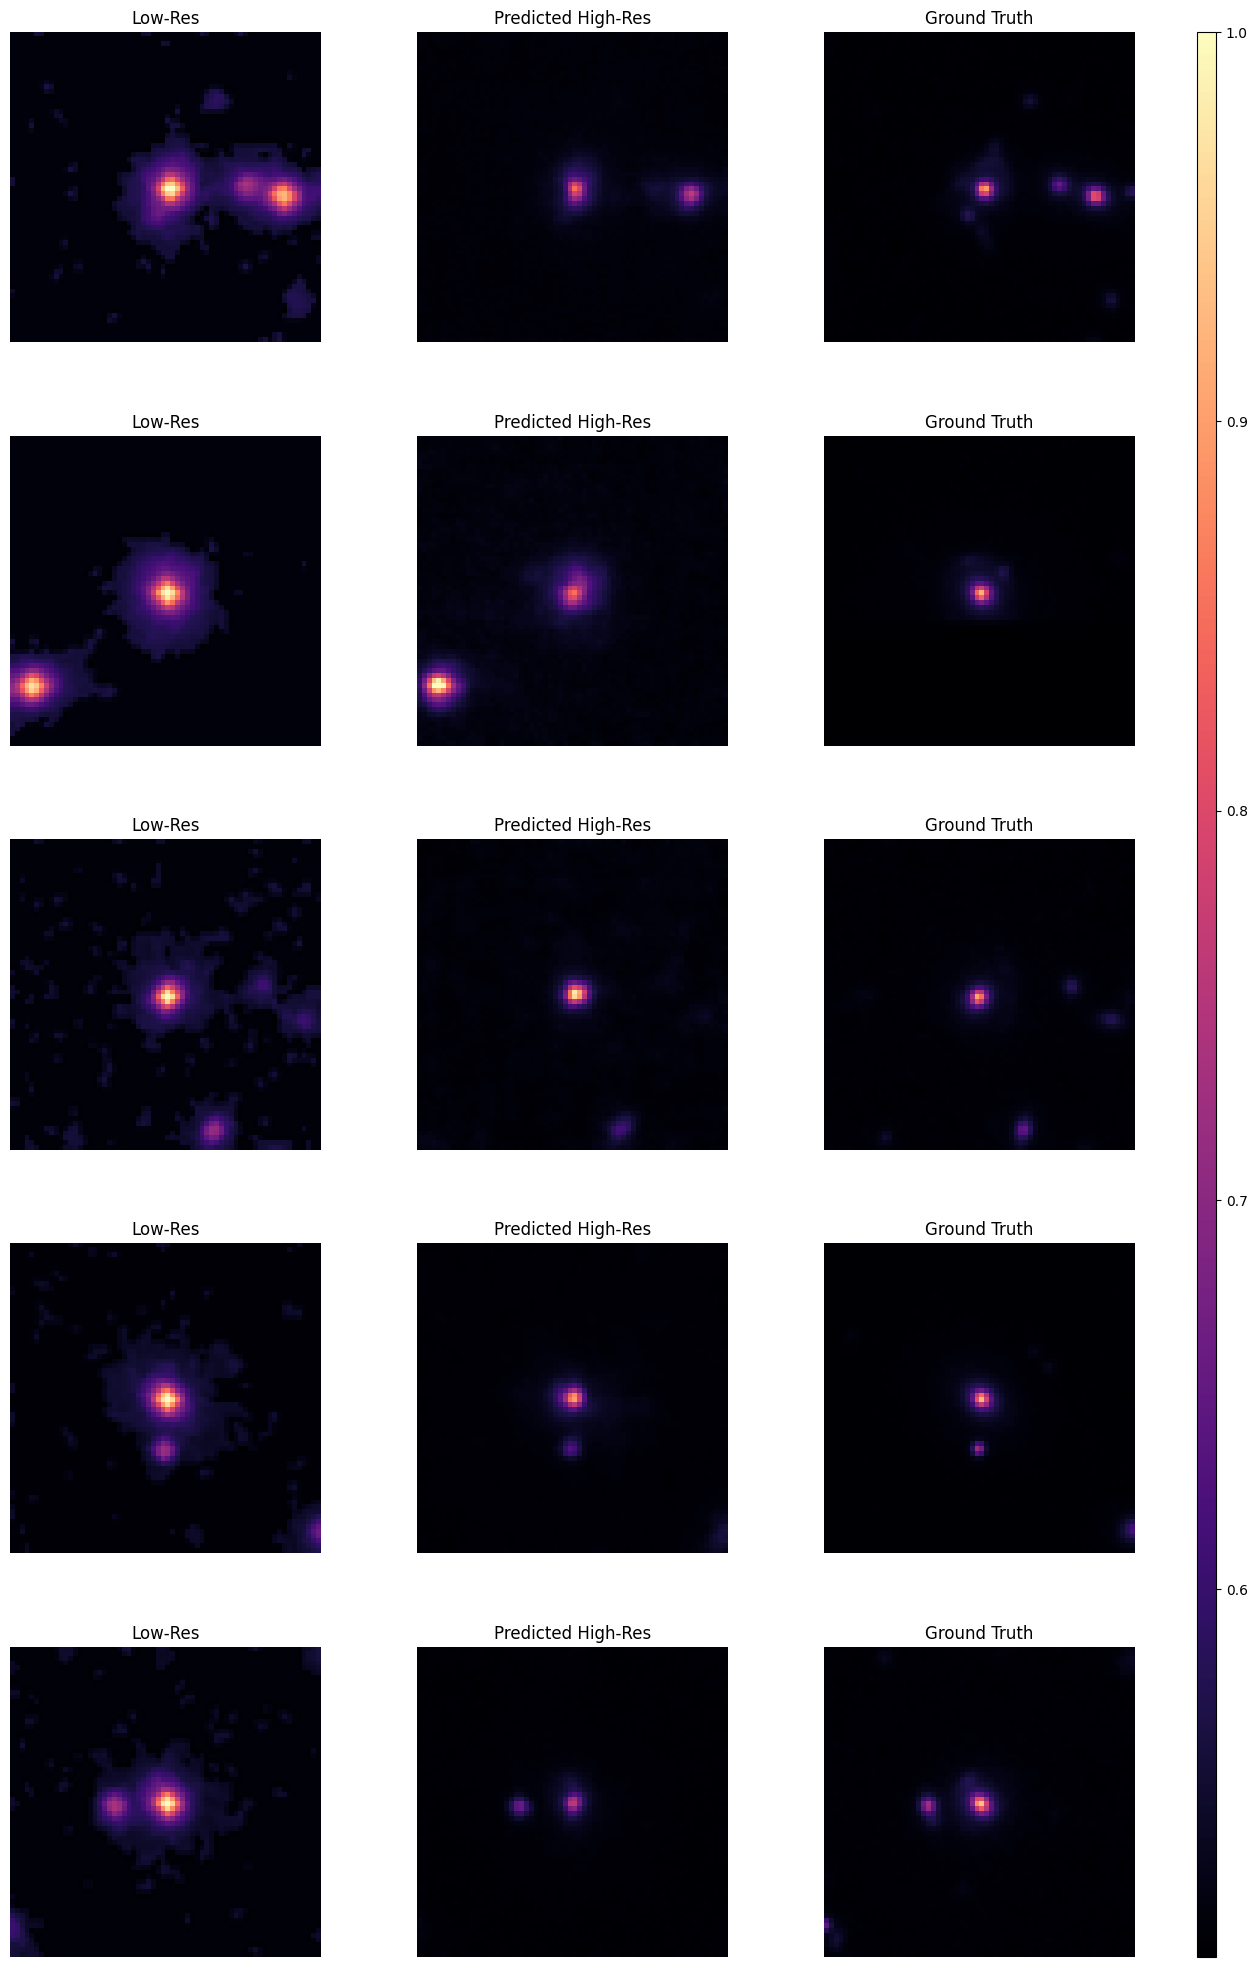

In [7]:
vmax_lr = 1
vmax_hr = 1
# Number of samples to visualize
num_rows = 5
n_samples = num_rows

# --- Get a batch from the test loader ---
(high_res_batch, low_res_batch) = next(iter(test_loader))
high_res_batch = high_res_batch[:n_samples].to(DEVICE)
low_res_batch = low_res_batch[:n_samples].to(DEVICE)

# --- Generate model predictions ---
with torch.no_grad():
    ema_model.eval()
    preds = sample_epsilon_conditional(ema_model, x_cond=low_res_batch).cpu()

# Move inputs and labels to CPU
low_res_batch = (low_res_batch.cpu()+1)/2
high_res_batch = (high_res_batch.cpu()+1)/2

# --- Plotting ---
fig = plt.figure(figsize=(16, num_rows * 5))
gs = gridspec.GridSpec(num_rows, 4, width_ratios=[1, 1, 1, 0.05], wspace=0.1, hspace=0.3)

for i in range(n_samples):
    # Low-res input
    ax1 = plt.subplot(gs[i, 0])
    ax1.imshow(low_res_batch[i, 0], cmap="magma", vmax=vmax_lr)
    ax1.set_title("Low-Res")
    ax1.axis('off')

    # Model output
    ax2 = plt.subplot(gs[i, 1])
    ax2.imshow(preds[i, 0], cmap="magma", vmax=vmax_hr)
    ax2.set_title("Predicted High-Res")
    ax2.axis('off')

    # Ground truth
    ax3 = plt.subplot(gs[i, 2])
    im3 = ax3.imshow(high_res_batch[i, 0], cmap="magma", vmax=vmax_hr)
    ax3.set_title("Ground Truth")
    ax3.axis('off')

cbar_ax = plt.subplot(gs[:, 3])
plt.colorbar(im3, cax=cbar_ax)

plt.tight_layout()
plt.show()
